(model-serving-get-started)=
# Model serving graph


**In this section**
- [Serving Functions](#serving-functions)
- [Topology](#topology)
- [Remote execution](#remote-execution)
- [Examples of graph functionality](#examples)

## Serving Functions

To start using a serving graph, you first need a serving function. A serving function contains the serving
class code to run the model and all the code necessary to run the tasks. MLRun comes with a wide library of tasks. If you
use just those, you don't have to add any special code to the serving function, you just have to provide
the code that runs the model. For more information about serving classes see {ref}`custom-model-serving-class`.

For example, the following code is a basic model serving class:

In [1]:
# mlrun: start-code

In [2]:
from cloudpickle import load
from typing import List
import numpy as np

import mlrun

class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [3]:
# mlrun: end-code

To obtain the serving function, use the `code_to_function` and specify `kind` to be `serving`.

In [4]:
fn = mlrun.code_to_function("serving_example",
                            kind="serving", 
                            image="mlrun/mlrun")

## Topology

### Router
Once you have a serving function, you need to choose the graph topology. The default is `router` topology. With the `router` topology you can specify different machine learning models. Each model has a logical name. This name is used to route to the correct model when calling the serving function.

In [5]:
from sklearn.datasets import load_iris

# set the topology/router
graph = fn.set_topology("router")

# Add the model
fn.add_model("model1", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")

# Add additional models
#fn.add_model("model2", class_name="ClassifierModel", model_path="<path2>")

# create and use the graph simulator
server = fn.to_mock_server()
x = load_iris()['data'].tolist()
result = server.test("/v2/models/model1/infer", {"inputs": x})

print(result)

> 2021-11-02 04:18:36,925 [info] model model1 was loaded
> 2021-11-02 04:18:36,926 [info] Initializing endpoint records
> 2021-11-02 04:18:36,965 [info] Loaded ['model1']
{'id': '6bd11e864805484ea888f58e478d1f91', 'model_name': 'model1', 'outputs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}


### Flow

You can use the `flow` topology to specify tasks, which typically manipulates the data. The most common scenario is pre-processing of data prior to the model execution.

```{note} Once the topology is set, you cannot change an existing function toplogy.
```

In this topology, you build and connect the graph (DAG) by adding steps using the `step.to()` method, or by using the 
`graph.add_step()` method.

> The `step.to()` is typically used to chain steps together. `graph.add_step` can add steps anywhere on the
> graph and has `before` and `after` parameters to specify the location of the step.

<!-- show example without router -->

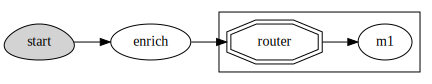

In [18]:
fn2 = mlrun.code_to_function("serving_example_flow",
                             kind="serving", 
                             image="mlrun/mlrun")

graph2 = fn2.set_topology("flow")     

graph2_enrich = graph2.to("storey.Extend", name="enrich", _fn='({"tag": "something"})')

# add an Ensemble router with two child models (routes)
router = graph2.add_step(mlrun.serving.ModelRouter(), name="router", after="enrich")
router.add_route("m1", class_name="ClassifierModel", model_path='https://s3.wasabisys.com/iguazio/models/iris/model.pkl')
router.respond()

# Add additional models
#router.add_route("m2", class_name="ClassifierModel", model_path=path2)

# plot the graph (using Graphviz)
graph2.plot(rankdir='LR')

In [7]:
fn2_server = fn2.to_mock_server()

result = fn2_server.test("/v2/models/m1/infer", {"inputs": x})

print(result)

> 2021-11-02 04:18:42,142 [info] model m1 was loaded
> 2021-11-02 04:18:42,142 [info] Initializing endpoint records
> 2021-11-02 04:18:42,183 [info] Loaded ['m1']
{'id': 'f713fd7eedeb431eba101b13c53a15b5'}


## Remote execution

You can chain functions together with remote execution. This allows you to:
- Call existing functions from the graph and reuse them from other graphs.
- Scale up and down different components individually.

Calling a remote function can either use HTTP or via a queue (streaming).

### HTTP

Calling a function using http uses the special `$remote` class. First deploy the remote function:

In [5]:
remote_func_name = "serving-example-flow"
project_name = "graph-basic-concepts"
fn_remote = mlrun.code_to_function(remote_func_name,
                                   project=project_name,
                                   kind="serving", 
                                   image="mlrun/mlrun")

fn_remote.add_model("model1", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")

remote_addr = fn_remote.deploy()

> 2022-03-17 08:20:40,674 [info] Starting remote function deploy
2022-03-17 08:20:40  (info) Deploying function
2022-03-17 08:20:40  (info) Building
2022-03-17 08:20:40  (info) Staging files and preparing base images
2022-03-17 08:20:40  (info) Building processor image
2022-03-17 08:20:42  (info) Build complete
2022-03-17 08:20:47  (info) Function deploy complete
> 2022-03-17 08:20:48,289 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-graph-basic-concepts-serving-example-flow.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['graph-basic-concepts-serving-example-flow-graph-basic-concepts.default-tenant.app.maor-gcp2.iguazio-cd0.com/']}


Create a new function with a graph and call the remote function above:

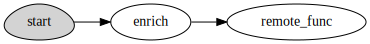

In [6]:
fn_preprocess = mlrun.new_function("preprocess", kind="serving")
graph_preprocessing = fn_preprocess.set_topology("flow")

graph_preprocessing.to("storey.Extend", name="enrich", _fn='({"tag": "something"})').to(
                       "$remote", "remote_func", url=f'{remote_addr}v2/models/model1/infer', method='put').respond()

graph_preprocessing.plot(rankdir='LR')

In [7]:
fn3_server = fn_preprocess.to_mock_server()
my_data = '''{"inputs":[[5.1, 3.5, 1.4, 0.2],[7.7, 3.8, 6.7, 2.2]]}'''
result = fn3_server.test("/v2/models/my_model/infer", body=my_data)
print(result)

> 2022-03-17 08:20:48,374 [warning] run command, file or code were not specified
{'id': '3a1dd36c-e7de-45af-a0c4-72e3163ba92a', 'model_name': 'model1', 'outputs': [0, 2]}


### Queue (streaming)

You can use queues to send events from one part of the graph to another and to decouple the processing of those parts.
Queues are better suited to deal with bursts of events, since all the events are stored in the queue until they are processed.

You can configure [different consumer groups for individual steps following queue steps](#configure-the-consumer-group-for-steps-following-queue-steps).

(serving-v3io-stream-example)=
#### V3IO stream example
The example below uses a V3IO stream, which is a fast real-time implementation of a stream that allows processing of events at very low latency.

In [8]:
%%writefile echo.py
def echo_handler(x):
    print(x)
    return x

Overwriting echo.py


Configure the streams

In [9]:
import os
streams_prefix = f"v3io:///users/{os.getenv('V3IO_USERNAME')}/examples/graph-basic-concepts"

input_stream = streams_prefix + "/in-stream"
out_stream = streams_prefix + "/out-stream"
err_stream = streams_prefix + "/err-stream"

Alternativey, use Kafka to configure the streams:

In [ ]:
kafka_prefix = f"kafka://{broker}/"
internal_topic = kafka_prefix + "in-topic"
out_topic = kafka_prefix + "out-topic"
err_topic = kafka_prefix + "err-topic"

Create the graph. Note that in the `to` method the class name is specified to be `>>` or `$queue` to specify that this is a queue.

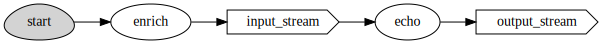

In [10]:
fn_preprocess2 = mlrun.new_function("preprocess", kind="serving")
fn_preprocess2.add_child_function('echo_func', './echo.py', 'mlrun/mlrun')

graph_preprocess2 = fn_preprocess2.set_topology("flow")

graph_preprocess2.to("storey.Extend", name="enrich", _fn='({"tag": "something"})')\
                 .to(">>", "input_stream", path=input_stream)\
                 .to(name="echo", handler="echo_handler", function="echo_func")\
                 .to(">>", "output_stream", path=out_stream, sharding_func="partition")

graph_preprocess2.plot(rankdir='LR')

In [11]:
from echo import *

fn4_server = fn_preprocess2.to_mock_server(current_function="*")

my_data = '''{"inputs": [[5.1, 3.5, 1.4, 0.2], [7.7, 3.8, 6.7, 2.2]], "partition": 0}'''

result = fn4_server.test("/v2/models/my_model/infer", body=my_data)

print(result)

> 2022-03-17 08:20:55,182 [warning] run command, file or code were not specified
{'id': 'a6efe8217b024ec7a7e02cf0b7850b91'}
{'inputs': [[5.1, 3.5, 1.4, 0.2], [7.7, 3.8, 6.7, 2.2]], 'tag': 'something'}


(serving-kafka-stream-example)=
#### Kafka stream example

In [1]:
%%writefile echo.py
def echo_handler(x):
    print(x)
    return x

Overwriting echo.py


Configure the streams

In [ ]:
import os

input_topic = "in-topic"
out_topic = "out-topic"
err_topic = "err-topic"

# replace this
brokers = "<broker IP>"

Create the graph. Note that in the `to` method the class name is specified to be `>>` or `$queue` to specify that this is a queue.

In [ ]:
import mlrun

fn_preprocess2 = mlrun.new_function("preprocess", kind="serving")
fn_preprocess2.add_child_function('echo_func', './echo.py', 'mlrun/mlrun')

graph_preprocess2 = fn_preprocess2.set_topology("flow")

graph_preprocess2.to("storey.Extend", name="enrich", _fn='({"tag": "something"})')\
                 .to(">>", "input_stream", path=input_topic, kafka_bootstrap_servers=brokers)\
                 .to(name="echo", handler="echo_handler", function="echo_func")\
                 .to(">>", "output_stream", path=out_topic, kafka_bootstrap_servers=brokers)

graph_preprocess2.plot(rankdir='LR')

from echo import *

fn4_server = fn_preprocess2.to_mock_server(current_function="*")

fn4_server.set_error_stream(f"kafka://{brokers}/{err_topic}")

my_data = '''{"inputs":[[5.1, 3.5, 1.4, 0.2],[7.7, 3.8, 6.7, 2.2]]}'''

result = fn4_server.test("/v2/models/my_model/infer", body=my_data)

print(result)

### Configure the consumer group for steps following queue steps

You can configure different consumer groups for each downstream branch/step following a queue step. 

In [ ]:
graph.to(
 ">>",
 "myqueue",
 path=f"v3io:///mycontainer/mystream",
 group="mygroup",
).to(
  ...
)

For more details, see [Building distributed graphs](https://docs.mlrun.org/en/latest/serving/realtime-pipelines.html#building-distributed-graphs), and {py:meth}`~mlrun.serving.QueueStep`.

## Examples of graph functionality

### NLP processing pipeline with real-time streaming 

In some cases it's useful to split your processing to multiple functions and use 
streaming protocols to connect those functions. 

See the [full notebook example](./distributed-graph.html), where the data processing is in the first function/container and the NLP processing is in the second function. And the second function contains the GPU.

Currently queues support Iguazio v3io and Kafka streams.

### Graph that splits and rejoins

You can define a graph that splits into two parallel steps, and the output of both steps join back together. 

In this basic example, all input goes into both stepA and stepB, and then both stepA and stepB forward the input to stepC. 
This means that a dataset of 5 rows generates an output of 10 rows (barring any filtering or other processing that 
would change the number of rows).

```{admonition} Note
Use this configuration to join the graph branches and **not** to join the events into a single large one.
``` 

Example:

In [ ]:
graph.to("stepB")
graph.to("stepC")
graph.add_step(name="stepD", after=["stepB", "stepC"])


graph = fn.set_topology("flow", exist_ok=True)
dbl = graph.to(name="double", handler="double")
dbl.to(name="add3", class_name="Adder", add=3)
dbl.to(name="add2", class_name="Adder", add=2)
graph.add_step("Gather").after("add2", "add3")

Graphs that split and rejoin can also be used for these types of scenarios:
- Steps B and C are filter steps that complement each other. For example B passes events where key < X, and C passes events where key >= X. The resulting DF contains the exact event ingested, since each event was handled once on one of the branches.
- Steps B and C modify the content of the event in different ways. B adds a column col1 with value X, and C adds a column col2 with value X. The resulting DF contains both col1 and col2. Each key is represented twice: once with col1 == X, col2 == null and once with col1 == null, col2 == X.